In [1]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import geopandas as gpd
import pandas as pd
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from shapely.geometry import Point

from geo_pyspark.register import GeoSparkRegistrator
from geo_pyspark.register import upload_jars
from geo_pyspark.core.SpatialRDD import SpatialRDD
from geo_pyspark.core.SpatialRDD import PointRDD
from geo_pyspark.core.SpatialRDD import PolygonRDD
from geo_pyspark.core.SpatialRDD import LineStringRDD
from geo_pyspark.core.enums import FileDataSplitter
from geo_pyspark.utils.adapter import Adapter
from geo_pyspark.core.spatialOperator import KNNQuery
from geo_pyspark.core.spatialOperator import JoinQuery
from geo_pyspark.core.spatialOperator import RangeQuery
from geo_pyspark.core.formatMapper.shapefileParser import ShapefileReader
from geo_pyspark.core.formatMapper import WkbReader
from geo_pyspark.core.formatMapper import WktReader
from geo_pyspark.core.formatMapper import GeoJsonReader
from geo_pyspark.sql.types import GeometryType
from geo_pyspark.core.enums import GridType
from geo_pyspark.core.SpatialRDD import RectangleRDD
from geo_pyspark.core.enums import IndexType
from geo_pyspark.core.geom.envelope import Envelope
from geo_pyspark.utils import GeoSparkKryoRegistrator, KryoSerializer

In [2]:
upload_jars()

True

In [3]:
spark = SparkSession.\
    builder.\
    master("local[*]").\
    appName("GeoPySparkCoreExample").\
    config("spark.serializer", KryoSerializer.getName).\
    config("spark.kryo.registrator", GeoSparkKryoRegistrator.getName) .\
    getOrCreate()

In [4]:
GeoSparkRegistrator.registerAll(spark)

True

In [5]:
sc = spark.sparkContext

# Create SpatialRDD

In [6]:
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, True, 10, StorageLevel.MEMORY_ONLY)

In [7]:
point_rdd.rawSpatialRDD.take(1)

[Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [8]:
point_rdd.analyze()

True

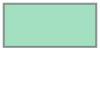

In [9]:
point_rdd.boundaryEnvelope

In [10]:
point_rdd.spatialPartitioning(GridType.EQUALGRID)

True

In [11]:
point_rdd.grids

## Transforming to GeoPandas

In [12]:
### Directly from RDD

In [13]:
point_rdd_to_geo = point_rdd.rawSpatialRDD.map(lambda x: [x.geom, *x.getUserData().split("\t")])

In [14]:
point_gdf = gpd.GeoDataFrame(
    point_rdd_to_geo.collect(), columns=["geom", "attr1", "attr2", "attr3"], geometry="geom"
)

In [15]:
point_gdf[:5]

,geom,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.22110 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.32399 32.95067),testattribute0,testattribute1,testattribute2


In [16]:
### Using Adapter

In [17]:
spatial_df = Adapter.\
    toDf(point_rdd, ["attr1", "attr2", "attr3"], spark).\
    createOrReplaceTempView("spatial_df")

spatial_gdf = spark.sql("Select attr1, attr2, attr3, st_GeomFromWKT(geometry) as geom from spatial_df")

In [18]:
spatial_gdf.show(5, False)

+--------------+--------------+--------------+----------------------------+
|attr1         |attr2         |attr3         |geom                        |
+--------------+--------------+--------------+----------------------------+
|testattribute0|testattribute1|testattribute2|POINT (-88.331492 32.324142)|
|testattribute0|testattribute1|testattribute2|POINT (-88.175933 32.360763)|
|testattribute0|testattribute1|testattribute2|POINT (-88.388954 32.357073)|
|testattribute0|testattribute1|testattribute2|POINT (-88.221102 32.35078) |
|testattribute0|testattribute1|testattribute2|POINT (-88.323995 32.950671)|
+--------------+--------------+--------------+----------------------------+
only showing top 5 rows



In [19]:
spatial_gdf.printSchema()

root
 |-- attr1: string (nullable = true)
 |-- attr2: string (nullable = true)
 |-- attr3: string (nullable = true)
 |-- geom: geometry (nullable = false)



In [20]:
point_gdf = gpd.GeoDataFrame(spatial_gdf.toPandas(), geometry="geom")

In [21]:
point_gdf[:5]

,attr1,attr2,attr3,geom
0,testattribute0,testattribute1,testattribute2,POINT (-88.33149 32.32414)
1,testattribute0,testattribute1,testattribute2,POINT (-88.17593 32.36076)
2,testattribute0,testattribute1,testattribute2,POINT (-88.38895 32.35707)
3,testattribute0,testattribute1,testattribute2,POINT (-88.22110 32.35078)
4,testattribute0,testattribute1,testattribute2,POINT (-88.32399 32.95067)


In [22]:
### With DataFrame creation

In [23]:
schema = StructType(
    [
        StructField("geometry", GeometryType(), False),
        StructField("attr1", StringType(), False),
        StructField("attr2", StringType(), False),
        StructField("attr3", StringType(), False),
    ]
)

In [24]:
geo_df = spark.createDataFrame(point_rdd_to_geo, schema, verifySchema=False)

In [25]:
geo_df.printSchema()

root
 |-- geometry: geometry (nullable = false)
 |-- attr1: string (nullable = false)
 |-- attr2: string (nullable = false)
 |-- attr3: string (nullable = false)



In [26]:
geo_df.show(5, False)

+----------------------------+--------------+--------------+--------------+
|geometry                    |attr1         |attr2         |attr3         |
+----------------------------+--------------+--------------+--------------+
|POINT (-88.331492 32.324142)|testattribute0|testattribute1|testattribute2|
|POINT (-88.175933 32.360763)|testattribute0|testattribute1|testattribute2|
|POINT (-88.388954 32.357073)|testattribute0|testattribute1|testattribute2|
|POINT (-88.221102 32.35078) |testattribute0|testattribute1|testattribute2|
|POINT (-88.323995 32.950671)|testattribute0|testattribute1|testattribute2|
+----------------------------+--------------+--------------+--------------+
only showing top 5 rows



In [27]:
point_gdf = gpd.GeoDataFrame(geo_df.toPandas(), geometry="geometry")

In [28]:
point_gdf[:5]

,geometry,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.22110 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.32399 32.95067),testattribute0,testattribute1,testattribute2


# Load Typed SpatialRDDs

In [29]:
rectangle_rdd = RectangleRDD(sc, "data/zcta510-small.csv", FileDataSplitter.CSV, True, 11)
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, False, 11)
polygon_rdd = PolygonRDD(sc, "data/primaryroads-polygon.csv", FileDataSplitter.CSV, True, 11)
linestring_rdd = LineStringRDD(sc, "data/primaryroads-linestring.csv", FileDataSplitter.CSV, True, StorageLevel.MEMORY_ONLY)

In [30]:
rectangle_rdd.analyze()
point_rdd.analyze()
polygon_rdd.analyze()
linestring_rdd.analyze()

True

# Spatial Partitioning

In [31]:
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

# Create Index

In [32]:
point_rdd.buildIndex(IndexType.RTREE, True)

# SpatialJoin

In [33]:
## PointRDD with RectangleRDD 

In [34]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())

In [35]:
point_rdd.buildIndex(IndexType.RTREE, True)

In [36]:
result = JoinQuery.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

In [37]:
result

MapPartitionsRDD[67] at map at GeoSerializerData.scala:137

In [38]:
result.take(1)

[[Geometry: Polygon userData: , Geometry: Point userData: ]]

In [39]:
schema = StructType(
    [
        StructField("geom_left", GeometryType(), False),
        StructField("geom_right", GeometryType(), False)
    ]
)

In [40]:
spatial_join_result = result.map(lambda x: [x[0].geom, x[1].geom])

In [41]:
spark.createDataFrame(spatial_join_result, schema, verifySchema=False).show(5, True)

+--------------------+--------------------+
|           geom_left|          geom_right|
+--------------------+--------------------+
|POLYGON ((-87.285...|POINT (-87.28468 ...|
|POLYGON ((-87.285...|POINT (-87.280556...|
|POLYGON ((-87.285...|POINT (-87.28285 ...|
|POLYGON ((-86.860...|POINT (-86.818935...|
|POLYGON ((-86.860...|POINT (-86.602919...|
+--------------------+--------------------+
only showing top 5 rows



In [42]:
spark.createDataFrame(spatial_join_result, schema, verifySchema=False).printSchema()

root
 |-- geom_left: geometry (nullable = false)
 |-- geom_right: geometry (nullable = false)



In [43]:
## or using adapter

In [44]:
Adapter.toDf(result, ["attr1"], ["attr2"], spark).show(5, True)

+--------------------+-----+--------------------+-----+
|              geom_1|attr1|              geom_2|attr2|
+--------------------+-----+--------------------+-----+
|POLYGON ((-87.285...|     |POINT (-87.28468 ...|     |
|POLYGON ((-87.285...|     |POINT (-87.280556...|     |
|POLYGON ((-87.285...|     |POINT (-87.28285 ...|     |
|POLYGON ((-86.860...|     |POINT (-86.818935...|     |
|POLYGON ((-86.860...|     |POINT (-86.602919...|     |
+--------------------+-----+--------------------+-----+
only showing top 5 rows



In [45]:
Adapter.toDf(result, ["attr1"], ["attr2"], spark).printSchema()

root
 |-- geom_1: geometry (nullable = true)
 |-- attr1: string (nullable = true)
 |-- geom_2: geometry (nullable = true)
 |-- attr2: string (nullable = true)



In [46]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())

In [47]:
spatial_join_result_non_flat = JoinQuery.SpatialJoinQuery(point_rdd, rectangle_rdd, False, True)

In [48]:
# number of point for each polygon
number_of_points = spatial_join_result_non_flat.map(lambda x: [x[0].geom, x[1].__len__()])

In [49]:
schema = StructType([
    StructField("geometry", GeometryType(), False),
    StructField("number_of_points", LongType(), False)
])

In [50]:
spark.createDataFrame(number_of_points, schema, verifySchema=False).show()

+--------------------+----------------+
|            geometry|number_of_points|
+--------------------+----------------+
|POLYGON ((-87.114...|              15|
|POLYGON ((-87.229...|               7|
|POLYGON ((-86.816...|               6|
|POLYGON ((-87.082...|              12|
|POLYGON ((-86.860...|              12|
|POLYGON ((-87.285...|              26|
|POLYGON ((-86.697...|               1|
|POLYGON ((-87.105...|              15|
|POLYGON ((-87.092...|               5|
|POLYGON ((-86.749...|               4|
+--------------------+----------------+



# KNNQuery

In [51]:
result = KNNQuery.SpatialKnnQuery(point_rdd, Point(-84.01, 34.01), 5, False)

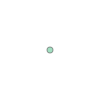

In [52]:
result[0].geom

In [53]:
result = KNNQuery.SpatialKnnQuery(rectangle_rdd, Point(-84.01, 34.01), 5, False)

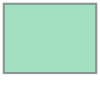

In [54]:
result[0].geom

In [55]:
polygon_nearby = KNNQuery.SpatialKnnQuery(polygon_rdd, Point(-84.01, 34.01), 5, False)

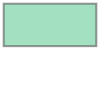

In [56]:
polygon_nearby[0].geom

In [57]:
example_polygon = polygon_nearby[0].geom

In [58]:
result = KNNQuery.SpatialKnnQuery(point_rdd, example_polygon, 20, False)

In [59]:
result[5].geom.wkt

'POINT (-85.49126699999999 34.203894)'

# RangeQuery

In [60]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

In [61]:
result_range_query = RangeQuery.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [62]:
result_range_query

MapPartitionsRDD[130] at map at GeoSerializerData.scala:82

In [63]:
result_range_query.collect()[:5]

[Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ]

In [64]:
schema = StructType([StructField("geometry", GeometryType(), False)])

In [65]:
spark.createDataFrame(
    result_range_query.map(lambda x: [x.geom]),
    schema,
    verifySchema=False
).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



# Load From other Formats

In [66]:
## ShapeFile - load to SpatialRDD

In [67]:
shape_rdd = ShapefileReader.readToGeometryRDD(sc, "data/polygon")

In [68]:
shape_rdd

In [69]:
Adapter.toDf(shape_rdd, spark).show(5, True)

+--------------------+---+
|            geometry|_c1|
+--------------------+---+
|MULTIPOLYGON (((1...|   |
|MULTIPOLYGON (((-...|   |
|MULTIPOLYGON (((1...|   |
|POLYGON ((118.362...|   |
|MULTIPOLYGON (((-...|   |
+--------------------+---+
only showing top 5 rows



In [70]:
## GeoJSON - load to SpatialRDD

In [71]:
geo_json_rdd = GeoJsonReader.readToGeometryRDD(sc, "data/testPolygon.json")

In [72]:
geo_json_rdd

In [73]:
Adapter.toDf(geo_json_rdd, spark).drop("AWATER").show(5, True)

+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|            geometry|STATEFP|COUNTYFP|TRACTCE|BLKGRPCE|            AFFGEOID|       GEOID|NAME|LSAD|   ALAND|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|POLYGON ((-87.621...|     01|     077| 011501|       5|1500000US01077011...|010770115015|   5|  BG| 6844991|
|POLYGON ((-85.719...|     01|     045| 021102|       4|1500000US01045021...|010450211024|   4|  BG|11360854|
|POLYGON ((-86.000...|     01|     055| 001300|       3|1500000US01055001...|010550013003|   3|  BG| 1378742|
|POLYGON ((-86.574...|     01|     089| 001700|       2|1500000US01089001...|010890017002|   2|  BG| 1040641|
|POLYGON ((-85.382...|     01|     069| 041400|       1|1500000US01069041...|010690414001|   1|  BG| 8243574|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
only showi

In [74]:
Adapter.toDf(geo_json_rdd, spark).drop("AWATER").printSchema()

root
 |-- geometry: string (nullable = true)
 |-- STATEFP: string (nullable = true)
 |-- COUNTYFP: string (nullable = true)
 |-- TRACTCE: string (nullable = true)
 |-- BLKGRPCE: string (nullable = true)
 |-- AFFGEOID: string (nullable = true)
 |-- GEOID: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LSAD: string (nullable = true)
 |-- ALAND: string (nullable = true)



In [75]:
## WKT - loading to SpatialRDD

In [76]:
wkt_rdd = WktReader.readToGeometryRDD(sc, "data/county_small.tsv", 0, True, False)

In [77]:
wkt_rdd

In [78]:
Adapter.toDf(wkt_rdd, spark).printSchema()

root
 |-- geometry: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)



In [79]:
Adapter.toDf(wkt_rdd, spark).show(5, True)

+--------------------+---+---+--------+-----+---------+----------------+---+---+-----+----+-----+----+----+----------+--------+-----------+------------+
|            geometry|_c1|_c2|     _c3|  _c4|      _c5|             _c6|_c7|_c8|  _c9|_c10| _c11|_c12|_c13|      _c14|    _c15|       _c16|        _c17|
+--------------------+---+---+--------+-----+---------+----------------+---+---+-----+----+-----+----+----+----------+--------+-----------+------------+
|POLYGON ((-97.019...| 31|039|00835841|31039|   Cuming|   Cuming County| 06| H1|G4020|    |     |    |   A|1477895811|10447360|+41.9158651|-096.7885168|
|POLYGON ((-123.43...| 53|069|01513275|53069|Wahkiakum|Wahkiakum County| 06| H1|G4020|    |     |    |   A| 682138871|61658258|+46.2946377|-123.4244583|
|POLYGON ((-104.56...| 35|011|00933054|35011|  De Baca|  De Baca County| 06| H1|G4020|    |     |    |   A|6015539696|29159492|+34.3592729|-104.3686961|
|POLYGON ((-96.910...| 31|109|00835876|31109|Lancaster|Lancaster County| 06| H1|G4

In [80]:
## WKB - load to SpatialRDD

In [81]:
wkb_rdd = WkbReader.readToGeometryRDD(sc, "data/county_small_wkb.tsv", 0, True, False)

In [82]:
Adapter.toDf(wkb_rdd, spark).show(5, True)

+--------------------+---+---+--------+-----+---------+----------------+---+---+-----+----+-----+----+----+----------+--------+-----------+------------+
|            geometry|_c1|_c2|     _c3|  _c4|      _c5|             _c6|_c7|_c8|  _c9|_c10| _c11|_c12|_c13|      _c14|    _c15|       _c16|        _c17|
+--------------------+---+---+--------+-----+---------+----------------+---+---+-----+----+-----+----+----+----------+--------+-----------+------------+
|POLYGON ((-97.019...| 31|039|00835841|31039|   Cuming|   Cuming County| 06| H1|G4020|    |     |    |   A|1477895811|10447360|+41.9158651|-096.7885168|
|POLYGON ((-123.43...| 53|069|01513275|53069|Wahkiakum|Wahkiakum County| 06| H1|G4020|    |     |    |   A| 682138871|61658258|+46.2946377|-123.4244583|
|POLYGON ((-104.56...| 35|011|00933054|35011|  De Baca|  De Baca County| 06| H1|G4020|    |     |    |   A|6015539696|29159492|+34.3592729|-104.3686961|
|POLYGON ((-96.910...| 31|109|00835876|31109|Lancaster|Lancaster County| 06| H1|G4